<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Pre%C3%A7o_justo_de_GORDON_e_BAZIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa bibliotecas

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


#Definição de Funções

###Obter dividendos

In [2]:

def coleta_dividendos(ticker):
    """
    Agrupa os dividendos por ano para uma ação específica.

    Args:
        ticker (str): O símbolo/ticker da ação (por exemplo, 'BBAS3.SA' para a Banco do Brasil S.A.).

    Returns:
        pandas.DataFrame: Um DataFrame contendo os dividendos agrupados por ano.
    """
    stock = yf.Ticker(ticker)
    dividend_history = stock.dividends.reset_index()  # Reseta o índice para que as datas se tornem uma coluna
    if dividend_history.empty:
        return None

    # Extrair o ano a partir da coluna de datas e, em seguida, agrupar por ano e somar os dividendos
    dividend_history['Year'] = dividend_history['Date'].dt.year
    dividendos_ano = dividend_history.groupby('Year')['Dividends'].sum()
    # print(dividends_by_year)
    return dividendos_ano


### Calcula média dos dividendos

In [3]:

def calcula_dividendo_medio(dividends_by_year, years=5):
    """
    Calcula a média histórica dos dividendos dos últimos n anos.

    Args:
        dividends_by_year (pandas.DataFrame): Um DataFrame contendo os dividendos agrupados por ano.
        years (int): O número de anos a considerar na média histórica.

    Returns:
        float: A média histórica dos dividendos dos últimos n anos.
    """
    current_year = datetime.datetime.now().year
    completed_years = dividends_by_year[dividends_by_year.index < current_year]
    # print(completed_years)
    return completed_years.tail(years).mean()


###Preço justo Gordon

In [4]:

def gordon_model(dividendo, taxa_retorno=0.06, taxa_crescimento=0.005):
    """
    Calcula o preço justo de uma ação usando o modelo Gordon Growth.

    Args:
        dividendo (float): O valor dos dividendos.
        taxa_retorno (float): A taxa de retorno exigida.
        taxa_crescimento (float): A taxa de crescimento dos dividendos.

    Returns:
        float: O preço justo da ação.
    """
    return dividendo / (taxa_retorno - taxa_crescimento)


###Preço justo Bazin

In [5]:

def bazin_model(dividendo, taxa_retorno=0.06):
    """
    Calcula o preço justo de uma ação usando o modelo de Bazin.

    Args:
        dividendo (float): Média dos últimos 5 anos de dividendos.

    Returns:
        float: O preço justo da ação.
    """
    return dividendo / taxa_retorno



###Gráfico de dividendos


In [6]:
def plot_annual_dividends(dividends_by_year):
    """
    Cria um gráfico de barras dos dividendos anualizados.

    Args:
        dividends_by_year (pandas.DataFrame): Um DataFrame contendo os dividendos agrupados por ano.
    """
    plt.figure(figsize=(10,6))
    bars = plt.bar(dividends_by_year.index, dividends_by_year.values)

    for bar in bars:
        yval = round(bar.get_height(), 2)
        plt.text(bar.get_x() + bar.get_width() / 2, yval, yval,
                 ha='center', va='bottom')

    plt.xlabel('Ano')
    plt.ylabel('Dividendos')
    plt.title('Dividendos por ano')
    plt.grid(True)
    plt.show()


###Gráfico da taxa de variação de crecimento e taxa média

In [7]:
def plot_growth_variation_and_average(dividendos, taxa_crescimento):
    """
    Cria um gráfico de linha com a variação do crescimento dos dividendos e a taxa média.

    Args:
        dividends_by_year (pandas.DataFrame): Um DataFrame contendo os dividendos agrupados por ano.
        average_growth_rate (float): A taxa de crescimento médio dos dividendos.
    """
    growth_rates = dividendos.pct_change().dropna() #* 100  # Converte para porcentagem
    years = growth_rates.index

    plt.figure(figsize=(10,6))
    plt.plot(years, growth_rates, label='Variação na Taxa de Dividendos')
    plt.axhline(y=taxa_crescimento*100, color='r', linestyle='-', label='Taxa Estimada de Crescimento de Dividendos')  # Multiplica por 100 para converter para porcentagem
    plt.xlabel('Ano')
    plt.ylabel('Taxa de Crescimento (%)')
    plt.title('Taxa de Crescimento de Dividendos & Taxa Média de Crescimento de Dividendos')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


#Resultado

###Preços

In [8]:
# Exemplo de uso:
#################################################################################################
ticker_symbol = "bbas3.sa"  # Substitua pelo símbolo/ticker da ação que você deseja consultar
taxa_retorno = 0.06  # Substitua pela taxa de retorno exigida
taxa_crescimento = 0.01  # Substitua pela taxa de crescimento
anos = 5
#################################################################################################

dividendos = coleta_dividendos(ticker_symbol)
if dividendos is not None:
    stock = yf.Ticker(ticker_symbol)
    media5_div = calcula_dividendo_medio(dividendos, anos) # estimativa do dividendo nos últimos 5 anos
    dy_div = stock.info['dividendYield']*stock.info['currentPrice'] # estimativa do dividendo pelo DY
    gordon = gordon_model(media5_div, taxa_retorno, taxa_crescimento)
    bazin = bazin_model(media5_div, taxa_retorno)

    print(f"O ativo é: {stock.info['symbol']}")
    print(f"O preço atual é: R$ {stock.info['currentPrice']}")
    print(f"A média histórica dos dividendos dos últimos {anos} anos completos é: R$ {media5_div:.2f}")
    print(f"A taxa de retorno estimada é: {taxa_retorno*100:.2f}%")
    print(f"A taxa de crescimento médio estimada de dividendos é: {taxa_crescimento*100:.2f}%")
    print(f"O preço justo da ação no modelo de Gordon, é: R$ {gordon:.2f}")
    print(f"O preço justo da ação no modelo de Bazin, é: R$ {bazin:.2f}")
else:
    print("Não foi possível obter dados históricos de dividendos para o símbolo/ticker fornecido.")


O ativo é: BBAS3.SA
O preço atual é: R$ 47.05
A média histórica dos dividendos dos últimos 5 anos completos é: R$ 2.17
A taxa de retorno estimada é: 6.00%
A taxa de crescimento médio estimada de dividendos é: 1.00%
O preço justo da ação no modelo de Gordon, é: R$ 43.36
O preço justo da ação no modelo de Bazin, é: R$ 36.13


Gráficos

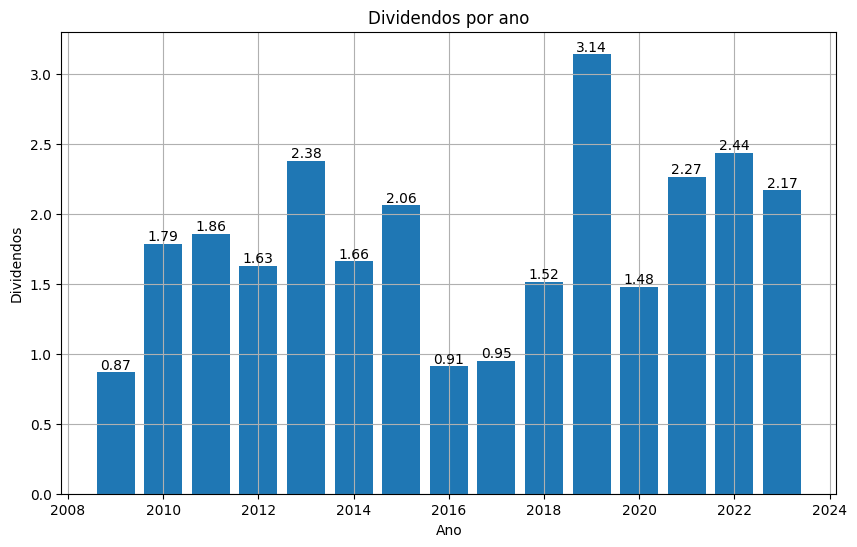

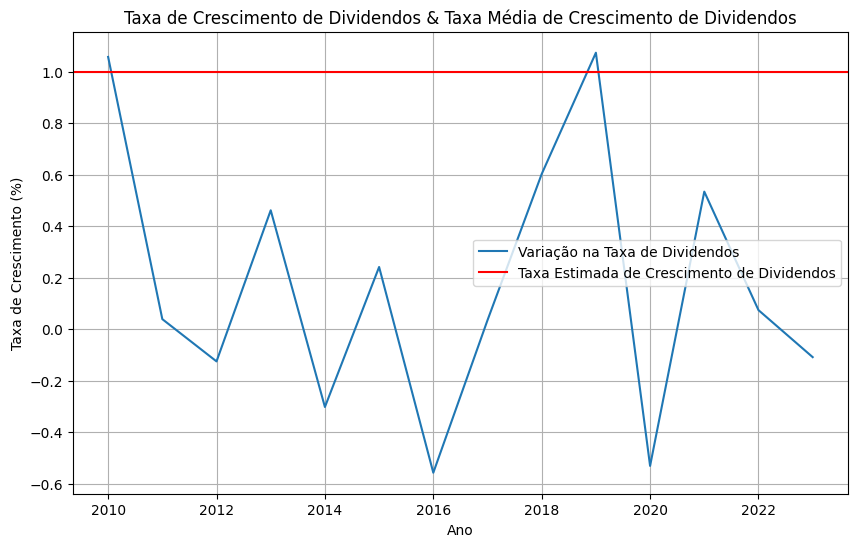

In [9]:
plot_annual_dividends(dividendos )
plot_growth_variation_and_average(dividendos, taxa_crescimento)  # Adicione esta linha para plotar o gráfico da variação do crescimento


#Comparação de ativos do IDIV

###Importação do IDIV - carteira de dividendos

##ATENÇÃO: CASO QUEIRA UTILIZAR O CSV OU XLSX, COMENTE AQUELE QUE NÃO VAI UTILIZAR!

In [13]:

# Caminho do arquivo XLSX no seu sistema
# file_path = '/content/IDIVDia_24-07-23.xlsx'
file_path = '/content/IDIVDia_24-07-23.csv'

# Use pandas para ler o arquivo XLSX ou CSV
# df = pd.read_excel(file_path)
df = pd.read_csv(file_path , sep=';' , decimal=',', index_col=False ,  thousands='.' , encoding='latin1') #Agradecimento ao seguidor do canal AgoraVAI - @Benjamin-ob8un

# Imprima as primeiras linhas do DataFrame para verificar se foi importado corretamente
df.head()


,codigo,acao,tipo,qtde_teorica,part
0,ABCB4,ABC BRASIL,PN N2,114105244,0.450
1,ALUP11,ALUPAR,UNT N2,236991795,1.431
2,B3SA3,B3,ON NM,1041121831,3.352
3,BRSR6,BANRISUL,PNB N1,329547255,1.043
4,BBSE3,BBSEGURIDADE,ON NM,474778215,3.128


In [14]:
# Cria uma nova série onde cada "codigo" é concatenado com ".SA"
tickers_series = df['codigo'].apply(lambda x: x + '.SA')

# Converte a série em um array numpy
tickers = tickers_series.to_numpy()

tickers


array(['ABCB4.SA', 'ALUP11.SA', 'B3SA3.SA', 'BRSR6.SA', 'BBSE3.SA',
       'BRAP4.SA', 'BBAS3.SA', 'AGRO3.SA', 'CMIG3.SA', 'CMIG4.SA',
       'CSMG3.SA', 'CPLE6.SA', 'CPFE3.SA', 'CMIN3.SA', 'CURY3.SA',
       'DIRR3.SA', 'ENAT3.SA', 'EGIE3.SA', 'FESA4.SA', 'GGBR4.SA',
       'GOAU4.SA', 'MYPK3.SA', 'RANI3.SA', 'ITSA4.SA', 'JBSS3.SA',
       'JHSF3.SA', 'KEPL3.SA', 'LAVV3.SA', 'MRFG3.SA', 'BEEF3.SA',
       'PETR3.SA', 'PETR4.SA', 'PSSA3.SA', 'RAPT4.SA', 'ROMI3.SA',
       'SANB11.SA', 'CSNA3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TRPL4.SA',
       'TRIS3.SA', 'UNIP6.SA', 'USIM5.SA', 'VALE3.SA', 'VBBR3.SA'],
      dtype=object)

##Calcula preço justo de várias ações

In [15]:

def calcular_precos_justos(tickers):
    """
    Calcula os preços justos de ações para uma lista de tickers utilizando os modelos de Gordon e Bazin.

    Args:
        tickers (list): Uma lista de strings contendo os tickers das ações que serão avaliadas.

    Returns:
        pandas.DataFrame: Um DataFrame contendo os preços justos, preços atuais e diferenças percentuais entre eles
        calculados pelos modelos de Gordon e Bazin para cada ação na lista de tickers.
    """
    data = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)

        # Coleta os dados de dividendos para a ação
        dividendos = coleta_dividendos(ticker)
        if dividendos is not None:
            # Calcula o dividendo médio dos últimos 5 anos
            media5_div = calcula_dividendo_medio(dividendos, 5)

            # Calcula o preço justo usando o Modelo de Gordon
            preço_justo_gordon = gordon_model(media5_div, taxa_retorno, taxa_crescimento)

            # Calcula o preço justo usando o Modelo de Bazin
            preço_justo_bazin = bazin_model(media5_div, taxa_retorno)

            # Obtém o preço atual da ação
            preço_atual = stock.info['currentPrice']

            # Calcula as diferenças entre o preço atual e os preços justos em porcentagem
            diff_gordon = (preço_atual / preço_justo_gordon - 1) * 100
            diff_bazin = (preço_atual / preço_justo_bazin - 1) * 100

            # Armazena os dados em uma lista para posterior criação do DataFrame
            data.append([stock.info['symbol'], preço_atual, preço_justo_gordon, diff_gordon, preço_justo_bazin, diff_bazin])
        else:
            print(f"Não foi possível obter dados históricos de dividendos para {ticker}.")

    # Cria o DataFrame com os dados coletados e retorna
    df = pd.DataFrame(data, columns=['Ticker', 'Preço Atual', 'Preço Justo Gordon', 'Diferença Gordon (%)', 'Preço Justo Bazin', 'Diferença Bazin (%)'])
    return df

# Exemplo de uso: Ações do DIVO11 em 24/07/2023
tickers = ['ABCB4.SA', 'ALUP11.SA', 'B3SA3.SA', 'BRSR6.SA', 'BBSE3.SA',
       'BRAP4.SA', 'BBAS3.SA', 'AGRO3.SA', 'CMIG3.SA', 'CMIG4.SA',
       'CSMG3.SA', 'CPLE6.SA', 'CPFE3.SA', 'CMIN3.SA', 'CURY3.SA',
       'DIRR3.SA', 'ENAT3.SA', 'EGIE3.SA', 'FESA4.SA', 'GGBR4.SA',
       'GOAU4.SA', 'MYPK3.SA', 'RANI3.SA', 'ITSA4.SA', 'JBSS3.SA',
       'JHSF3.SA', 'KEPL3.SA', 'LAVV3.SA', 'MRFG3.SA', 'BEEF3.SA',
       'PETR3.SA', 'PETR4.SA', 'PSSA3.SA', 'RAPT4.SA', 'ROMI3.SA',
       'SANB11.SA', 'CSNA3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TRPL4.SA',
       'TRIS3.SA', 'UNIP6.SA', 'USIM5.SA', 'VALE3.SA', 'VBBR3.SA']

precos_justos_df = calcular_precos_justos(tickers)
precos_justos_df.head()


,Ticker,Preço Atual,Preço Justo Gordon,Diferença Gordon (%),Preço Justo Bazin,Diferença Bazin (%)
0,ABCB4.SA,18.39,20.282160,-9.329184,16.901800,8.804979
1,ALUP11.SA,29.19,15.115384,93.114512,12.596153,131.737414
2,B3SA3.SA,14.67,9.950328,47.432326,8.291940,76.918791
3,BRSR6.SA,14.66,21.296004,-31.160794,17.746670,-17.392953
4,BBSE3.SA,31.23,47.128684,-33.734623,39.273903,-20.481548


### Gráfico de calor de preço atual e preço justo de Gordon e Bazin

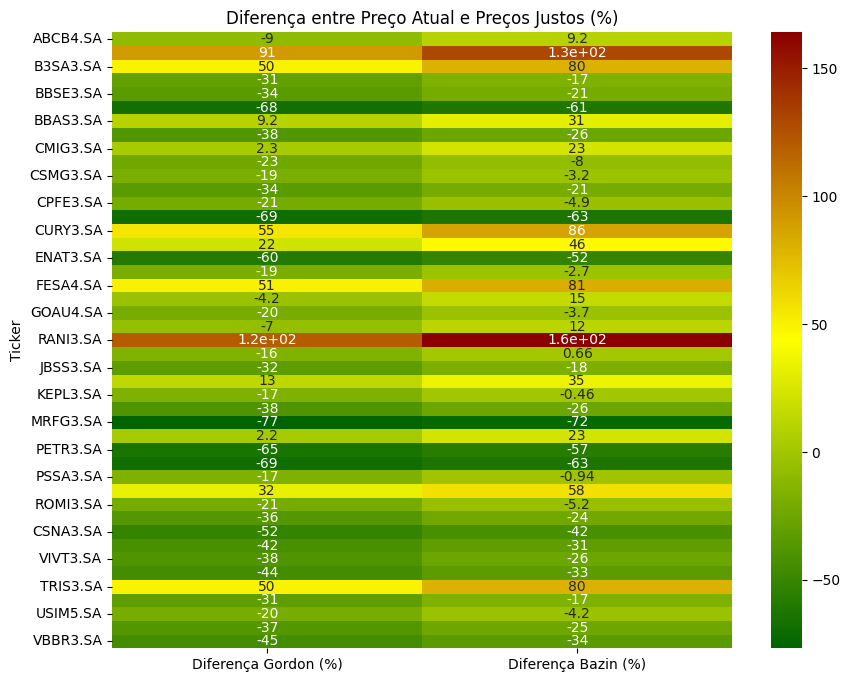

In [ ]:
# Para fazer um mapa de calor das diferenças:
#######################################
n = 1000
#######################################
heatmap_data = precos_justos_df.head(n).set_index('Ticker')[['Diferença Gordon (%)', 'Diferença Bazin (%)']]

# Cria uma paleta de cores personalizada
cmap = mcolors.LinearSegmentedColormap.from_list("", ["darkgreen", "yellow", "darkred"])

plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap=cmap, annot=True)
plt.title('Diferença entre Preço Atual e Preços Justos (%)')
plt.show()


#Obter e ordenar empresas com maiores DY

In [ ]:

def obter_dy(ticker):
    """
    Recupera o Dividend Yield de uma ação.

    Args:
        ticker (str): O símbolo/ticker da ação (por exemplo, 'AAPL' para a Apple Inc.).

    Returns:
        float: O Dividend Yield da ação.
    """
    stock = yf.Ticker(ticker)
    dividend_yield = stock.info['dividendYield']
    return dividend_yield

def obter_melhor_dividendo(tickers, top_n=10):
    """
    Obtém as melhores ações pagadoras de dividendos de uma lista de ações.

    Args:
        tickers (list): Uma lista de símbolos/tickers das ações.
        top_n (int): O número de ações top para retornar.

    Returns:
        pandas.DataFrame: Um DataFrame contendo as melhores ações pagadoras de dividendos.
    """
    dividend_yields = {}
    for ticker in tickers:
        dividend_yield = obter_dy(ticker)
        if dividend_yield is not None:
            dividend_yields[ticker] = dividend_yield

    # Cria um DataFrame a partir do dicionário
    df = pd.DataFrame(list(dividend_yields.items()), columns=['Ticker', 'Dividend Yield'])

    # Classifica o DataFrame com base no Dividend Yield
    df = df.sort_values('Dividend Yield', ascending=False)

    # Retorna as primeiras 'top_n' linhas
    return df.head(top_n)

# Exemplo de uso:
# tickers = ['bbas3.sa', 'itub4.sa', 'vale3.sa', 'bbse3.sa', 'taee11.sa', 'petr4.sa', 'abev3.sa', ]  # Substitua pela lista de símbolos/tickers das ações que você deseja consultar
melhores_dividendos = obter_melhor_dividendo(tickers, 20)
melhores_dividendos


,Ticker,Dividend Yield
30,PETR3.SA,0.4564
31,PETR4.SA,0.4504
28,MRFG3.SA,0.2253
7,AGRO3.SA,0.2111
36,CSNA3.SA,0.1781
41,UNIP6.SA,0.1560
12,CPFE3.SA,0.1525
5,BRAP4.SA,0.1446
19,GGBR4.SA,0.1256
4,BBSE3.SA,0.1223
